In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define transformations to be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract the data and labels from the datasets
X_train, y_train = train_set.data.numpy(), train_set.targets.numpy()
X_test, y_test = test_set.data.numpy(), test_set.targets.numpy()

# Reshape the data to be of size [N x 784]
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize the data to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

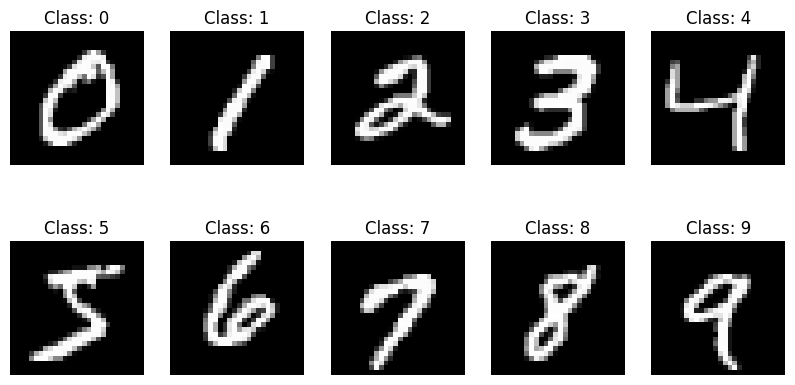

In [3]:
classes = np.unique(y_train)

# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[y_train == classes[i]][0].reshape(28, 28), cmap='gray')
    ax.set_title(f"Class: {classes[i]}")
    ax.axis('off')

plt.show()

In [4]:
print('Number of training examples: ', X_train.shape[0])
print('Number of testing examples: ', X_test.shape[0])
print('Each image is of size: ', X_train.shape[1])
print('There are {} classes: {}'.format(len(classes), classes))
print('The data is of type: ', X_train.dtype)
print('The labels are of type: ', y_train.dtype)
print('The range of the pixel values is [{}, {}]'.format(np.min(X_train), np.max(X_train)))

Number of training examples:  60000
Number of testing examples:  10000
Each image is of size:  784
There are 10 classes: [0 1 2 3 4 5 6 7 8 9]
The data is of type:  float64
The labels are of type:  int64
The range of the pixel values is [0.0, 1.0]


In [5]:
class LinearLayer():
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))

    def forward(self, x):
        self.x = x
        return np.dot(x, self.weights) + self.bias

    def backward(self, grad_output):
        self.weights_grad = np.dot(self.x.T, grad_output)
        self.bias_grad = np.sum(grad_output, axis=0, keepdims=True)
        return np.dot(grad_output, self.weights.T)

    def update(self, lr):
        self.weights -= lr * self.weights_grad
        self.bias -= lr * self.bias_grad

In [6]:
import unittest

class TestLinearLayer(unittest.TestCase):
    def setUp(self):
        self.input_size = 10
        self.output_size = 5
        self.linear_layer = LinearLayer(self.input_size, self.output_size)

    def test_forward(self):
        x = np.random.randn(1, self.input_size)
        output = self.linear_layer.forward(x)
        self.assertEqual(output.shape, (1, self.output_size))

    def test_backward(self):
        x = np.random.randn(1, self.input_size)
        output = self.linear_layer.forward(x)
        grad_output = np.random.randn(1, self.output_size)
        grad_input = self.linear_layer.backward(grad_output)
        self.assertEqual(grad_input.shape, (1, self.input_size))

unittest.main(argv=[''], verbosity=2, exit=False)

test_backward (__main__.TestLinearLayer.test_backward) ... ok
test_forward (__main__.TestLinearLayer.test_forward) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


In [7]:
# Helper functions
def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return x > 0

def sigmoid(x):
    x = np.clip(x, -500, 500) # clip x to prevent overflow
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def binary_cross_entropy(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent log(0) or log(1)
    loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)).mean()
    return loss

def binary_cross_entropy_grad(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent division by 0
    grad = (y_pred - y_true) / (y_pred * (1 - y_pred) + eps) # add eps to prevent division by 0
    return grad

In [8]:
class SingleLayerNetwork():
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.linear1 = LinearLayer(input_size, hidden_size)
        self.linear2 = LinearLayer(hidden_size, output_size)

    def forward(self, x):
        self.x = x
        self.h = relu(self.linear1.forward(x))
        self.y_pred = sigmoid(self.linear2.forward(self.h))
        return self.y_pred

    def backward(self, y_true):
        # reshape y_pred to be the same shape as y_true
        y_true = y_true.reshape(-1, 1)
        self.y_pred = self.y_pred.reshape(-1, 1)

        grad_output = binary_cross_entropy_grad(self.y_pred, y_true)
        grad_output = sigmoid_grad(self.y_pred) * grad_output
        grad_output = self.linear2.backward(grad_output)
        grad_output = relu_grad(self.h) * grad_output
        grad_output = self.linear1.backward(grad_output)
        return grad_output

    def update(self, lr):
        self.linear1.update(lr)
        self.linear2.update(lr)

    def train(self, X, y, lr, epochs, batch_size):
        for epoch in range(epochs):
            loss_list = []
            for i in range(0, len(X), batch_size):
                # create random batch with batch_size
                batch = np.random.choice(len(X), batch_size)
                X_batch = X[batch]
                y_batch = y[batch]
                
                # Forward pass
                y_pred = self.forward(X_batch)

                # Backward pass
                loss = binary_cross_entropy(y_pred, y_batch)
                loss_list.append(loss)
                self.backward(y_batch)
                self.update(lr)

            accuracy = self.evaluate(X, y)
            loss = np.mean(loss_list)
            print(f"Epoch {epoch+1} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_pred = np.round(y_pred)
        return np.mean(y_pred == y)

In [9]:
y_train_4 = (y_train == 4).astype(int)
y_test_4 = (y_test == 4).astype(int)

# Train the network
network = SingleLayerNetwork(input_size=784, hidden_size=128, output_size=1)
network.train(X_train, y_train_4, lr=0.1, epochs=10, batch_size=512)

Epoch 1 - Loss: 6.6283 - Accuracy: 0.9026
Epoch 2 - Loss: 6.9815 - Accuracy: 0.9026
Epoch 3 - Loss: 6.6070 - Accuracy: 0.9026
Epoch 4 - Loss: 6.6791 - Accuracy: 0.9026
Epoch 5 - Loss: 6.5441 - Accuracy: 0.9026
Epoch 6 - Loss: 6.9283 - Accuracy: 0.9026
Epoch 7 - Loss: 6.6448 - Accuracy: 0.9026
Epoch 8 - Loss: 6.6791 - Accuracy: 0.9026
Epoch 9 - Loss: 6.6796 - Accuracy: 0.9026
Epoch 10 - Loss: 6.9226 - Accuracy: 0.9026


In [10]:
def cross_entropy(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent log(0) or log(1)
    loss = -(y_true * np.log(y_pred)).sum(axis=1).mean()
    return loss

def cross_entropy_grad(y_pred, y_true):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps) # clip y_pred to prevent division by 0
    grad = y_pred - y_true
    return grad

def mse(y_pred, y_true):
    loss = ((y_pred - y_true) ** 2).mean()
    return loss

def mse_grad(y_pred, y_true):
    grad = 2 * (y_pred - y_true) / y_pred.size
    return grad

def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True) # prevent overflow
    x = np.exp(x)
    x = x / np.sum(x, axis=1, keepdims=True)
    return x

def softmax_grad(x):
    return softmax(x) * (1 - softmax(x))

def one_hot_encode(y):
    y_one_hot = np.zeros((len(y), 10))
    y_one_hot[np.arange(len(y)), y] = 1
    return y_one_hot

### Gradient of the Cross-Entropy loss function
The reason why the `cross_entropy_grad` function uses the difference between the predicted probabilities and the true labels, instead of the negative of the gradient of the cross-entropy loss with respect to the predicted probabilities, is that they are equivalent up to a constant factor.

Let's first consider the gradient of the cross-entropy loss with respect to the predicted logits, denoted as $\mathbf{z}$. The logits are related to the predicted probabilities via the softmax function:

$$
y_{i} = \frac{e^{z_{i}}}{\sum_{j} e^{z_{j}}}
$$

Taking the partial derivative of $\mathcal{L}$ with respect to $z_{j}$, we have:

$$
\frac{\partial \mathcal{L}}{\partial z_{j}} = \sum_{i} \frac{\partial \mathcal{L}}{\partial y_{i}} \frac{\partial y_{i}}{\partial z_{j}}
$$

Using the chain rule, we have:

$$
\frac{\partial y_{i}}{\partial z_{j}} = y_{i} (\delta_{ij} - y_{j})
$$

where $\delta_{ij}$ is the Kronecker delta function that is equal to 1 if $i = j$ and 0 otherwise. Substituting this expression into the above equation, we obtain:

$$
\frac{\partial \mathcal{L}}{\partial z_{j}} = \sum_{i} (\delta_{ij} - y_{j}) t_{i}
$$

This expression is equivalent to the difference between the predicted probabilities and the true labels. To see this, note that the predicted probabilities can be written as:

$$
y_{j} = \frac{e^{z_{j}}}{\sum_{k} e^{z_{k}}}
$$

Taking the derivative of $y_{j}$ with respect to $z_{j}$, we have:

$$
\frac{\partial y_{j}}{\partial z_{j}} = y_{j} (1 - y_{j})
$$

Substituting this expression into the gradient expression, we obtain:

$$
\frac{\partial \mathcal{L}}{\partial z_{j}} = y_{j} - t_{j}
$$

which is the difference between the predicted probabilities and the true labels. Thus, the `cross_entropy_grad` function is equivalent to the negative of the gradient of the cross-entropy loss with respect to the predicted probabilities, up to a constant factor.



In [11]:
class MultiLayerNetwork():
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.linear1 = LinearLayer(input_size, hidden_size)
        self.linear2 = LinearLayer(hidden_size, hidden_size)
        self.linear3 = LinearLayer(hidden_size, output_size)

    def forward(self, x):
        self.x = x
        self.h1 = relu(self.linear1.forward(x))
        self.h2 = relu(self.linear2.forward(self.h1))
        self.y_pred = softmax(self.linear3.forward(self.h2))
        return self.y_pred

    def backward(self, y_true):
        grad_output = cross_entropy_grad(self.y_pred, y_true)
        grad_output = softmax_grad(self.y_pred) * grad_output
        grad_output = self.linear3.backward(grad_output)
        grad_output = relu_grad(self.h2) * grad_output
        grad_output = self.linear2.backward(grad_output)
        grad_output = relu_grad(self.h1) * grad_output
        grad_output = self.linear1.backward(grad_output)
        return grad_output

    def update(self, lr):
        self.linear1.update(lr)
        self.linear2.update(lr)
        self.linear3.update(lr)

    def train(self, X, y, lr, epochs, batch_size):
        for epoch in range(epochs):
            loss_list = []
            for i in range(0, len(X), batch_size):
                # create random batch with batch_size
                batch = np.random.choice(len(X), batch_size)
                X_batch = X[batch]
                y_batch = y[batch]
                
                # Forward pass
                y_pred = self.forward(X_batch)

                # Backward pass
                loss = cross_entropy(y_pred, y_batch)
                loss_list.append(loss)
                self.backward(y_batch)
                self.update(lr)

            accuracy = self.evaluate(X, y)
            loss = np.mean(loss_list)
            print(f"Epoch {epoch+1} - Loss: {loss:.4f} - Accuracy: {accuracy:.4f}")

    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y = np.argmax(y, axis=1)
        return np.mean(y_pred == y)

In [12]:
# train the network
network = MultiLayerNetwork(input_size=784, hidden_size=256, output_size=10)

# one hot encode the labels
y_train_one_hot = one_hot_encode(y_train)
network.train(X_train, y_train_one_hot, lr=0.01, epochs=10, batch_size=46)

KeyboardInterrupt: 

In [ ]:
# evaluate the network on the test set
print(f"Accuracy: {network.evaluate(X_test, one_hot_encode(y_test)):.4f}")

In [ ]:
# plot 10 random images from the test set with their predicted labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    idx = np.random.choice(len(X_test))
    ax.imshow(X_test[idx].reshape(28, 28), cmap="gray")
    ax.set_title(f"Prediction: {network.predict(X_test[idx:idx+1])[0]}")
    ax.axis("off")
plt.show()
